In [2]:
## Ignore all warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Activation

Using TensorFlow backend.


In [36]:
%matplotlib inline 
import cv2
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output


In [6]:
image_train_dir = './data/tomatoes/train/'
image_test_dir = './data/tomatoes/test/'

## Create image training batches

In [8]:
from keras.preprocessing.image import ImageDataGenerator

In [11]:
train_generator = ImageDataGenerator(rescale=1./255)

In [24]:
train_data = train_generator.flow_from_directory(image_train_dir,
                                                 target_size=(256,256),
                                                 batch_size = 64,
                                                 class_mode='binary')
# 2 classes i.e, 2 directories with total 840 images

Found 840 images belonging to 2 classes.


In [25]:
train_data.n
train_data.class_indices

{'healthy': 0, 'unhealthy': 1}

In [26]:
train_data.image_shape

(256, 256, 3)

In [129]:
x_batch, y_batch = next(train_data)

In [34]:
y_batch

array([1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.,
       1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0.], dtype=float32)

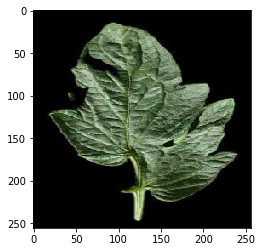

In [41]:
plt.imshow(x_batch[3])

In [47]:
y_batch[3]

0.0

### Build a test data generator

In [48]:
test_generator = ImageDataGenerator(rescale=1./255)

In [49]:
test_data = test_generator.flow_from_directory(image_test_dir,
                                                 target_size=(256,256),
                                                 batch_size = 64,
                                                 class_mode='binary')
# 2 classes i.e, 2 directories with total 840 images

Found 200 images belonging to 2 classes.


In [50]:
test_data.n

200

In [51]:
test_data.class_indices

{'healthy': 0, 'unhealthy': 1}

## Build a CNN Model

In [139]:
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPool2D, Dense, Activation, Flatten

In [66]:
model_v1 = Sequential()

#First convolution layer with 8 filter 
model_v1.add(Conv2D(filters=8, 
                    kernel_size=(3,3),
                    input_shape = train_data.image_shape))

model_v1.add(MaxPool2D(2,2))

#First convolution layer with 4 filter 

model_v1.add(Conv2D(filters=4, 
                    kernel_size=(3,3),
                    input_shape = train_data.image_shape))

model_v1.add(MaxPool2D(2,2))

#Flatten

# 1st layer of Dense and activation

model_v1.add(keras.layers.Flatten())
model_v1.add(Dense(64))
model_v1.add(Activation('relu'))

# 2nd layer of Dense and activation
model_v1.add(Dense(16))
model_v1.add(Activation('relu'))

# Add output layer 
model_v1.add(Dense(1))
model_v1.add(Activation('sigmoid'))



In [67]:
model_v1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 254, 254, 8)       224       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 127, 127, 8)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 125, 125, 4)       292       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 62, 62, 4)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 15376)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                984128    
_________________________________________________________________
activation_6 (Activation)    (None, 64)                0         
__________

In [68]:
model_v1.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [72]:
%%time 
EPOCHS=10

# fit model
history = model_v1.fit_generator(
    train_data,
    steps_per_epoch = EPOCHS,
    epochs=10,
    validation_data = test_data,
    validation_steps=2
)

Epoch 1/10
10/10 [==============================] - 56s 6s/step - loss: 0.6559 - acc: 0.6050 - mean_squared_error: 0.2326 - val_loss: 0.5126 - val_acc: 0.7400 - val_mean_squared_error: 0.1755
Epoch 2/10
10/10 [==============================] - 62s 6s/step - loss: 0.6220 - acc: 0.6654 - mean_squared_error: 0.2167 - val_loss: 0.4572 - val_acc: 0.8650 - val_mean_squared_error: 0.1423
Epoch 3/10
10/10 [==============================] - 63s 6s/step - loss: 0.5117 - acc: 0.7525 - mean_squared_error: 0.1698 - val_loss: 1.9917 - val_acc: 0.5000 - val_mean_squared_error: 0.4747
Epoch 4/10
10/10 [==============================] - 70s 7s/step - loss: 0.6051 - acc: 0.7281 - mean_squared_error: 0.1905 - val_loss: 0.4609 - val_acc: 0.7650 - val_mean_squared_error: 0.1535
Epoch 5/10
10/10 [==============================] - 62s 6s/step - loss: 0.4631 - acc: 0.7844 - mean_squared_error: 0.1502 - val_loss: 0.3398 - val_acc: 0.9000 - val_mean_squared_error: 0.0979
Epoch 6/10
10/10 [======================

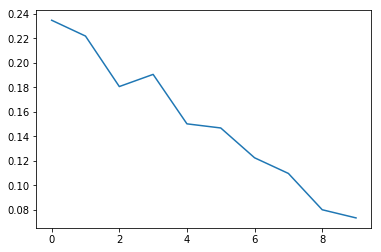

In [75]:
plt.plot(history.history['mean_squared_error'])

In [79]:
%%time 
EPOCHS=10
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



callback_list = [TensorBoard('./logs'),
                EarlyStopping(monitor='val_loss',
                             patience=4),
                ModelCheckpoint(filepath='tomatoes_disease.h5', save_best_only=True),
                ReduceLROnPlateau(monitor='val_loss',factor=0.1, patience=2)]

# fit model
history = model_v1.fit_generator(
    train_data,
    steps_per_epoch = EPOCHS,
    epochs=2,
    callbacks = callback_list,
    validation_data = test_data,
    validation_steps=2
)

Epoch 1/2
10/10 [==============================] - 69s 7s/step - loss: 0.1652 - acc: 0.9375 - mean_squared_error: 0.0482 - val_loss: 0.3482 - val_acc: 0.8700 - val_mean_squared_error: 0.0994
Epoch 2/2
10/10 [==============================] - 54s 5s/step - loss: 0.0417 - acc: 0.9968 - mean_squared_error: 0.0060 - val_loss: 0.3327 - val_acc: 0.8900 - val_mean_squared_error: 0.0942
Wall time: 2min 4s


## Predict on TEST DATA


In [140]:
train_data = train_generator.flow_from_directory(image_train_dir,
                                                 target_size=(256,256),
                                                 batch_size = 200,
                                                 class_mode='binary')
# 2 classes i.e, 2 directories with total 840 images

Found 840 images belonging to 2 classes.


In [141]:
model_v1 = Sequential()

#First convolution layer with 8 filter 
model_v1.add(Conv2D(filters=8, 
                    kernel_size=(3,3),
                    input_shape = train_data.image_shape))

model_v1.add(MaxPool2D(2,2))

#First convolution layer with 4 filter 

model_v1.add(Conv2D(filters=4, 
                    kernel_size=(3,3),
                    input_shape = train_data.image_shape))

model_v1.add(MaxPool2D(2,2))

#Flatten

# 1st layer of Dense and activation

model_v1.add(keras.layers.Flatten())
model_v1.add(Dense(64))
model_v1.add(Activation('relu'))

# 2nd layer of Dense and activation
model_v1.add(Dense(16))
model_v1.add(Activation('relu'))

# Add output layer 
model_v1.add(Dense(1))
model_v1.add(Activation('sigmoid'))


In [162]:
x_test, y_test = next(train_data)

In [166]:
print(x_test.shape, y_test.shape)

(200, 256, 256, 3) (200,)


In [143]:
y_pred_prob = model_v1.predict_proba(x_test)

In [144]:
# DataFrame containing a column containing actual values
y_df = pd.DataFrame({'actual': list(y_test.reshape(200)), 'prob': list(y_pred_prob.reshape(200))}) 

In [145]:
pred_y = model_v1.predict_generator(test_data)

In [146]:
pred_y.shape

(200, 1)

In [147]:
import seaborn as sn

C:\Users\kumasaji\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\kumasaji\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


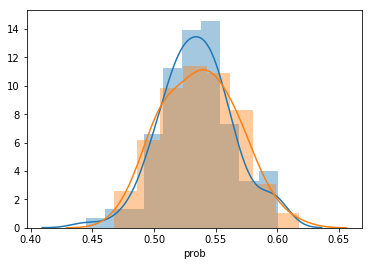

In [148]:
sn.distplot(y_df[y_df.actual ==1]['prob'], label = 'Unhealthy')
sn.distplot(y_df[y_df.actual ==0]['prob'], label = 'Healthy')

In [149]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [156]:
auc_score = roc_auc_score(y_df.actual, y_df.prob)

In [157]:
y_df.columns

Index(['actual', 'prob'], dtype='object')

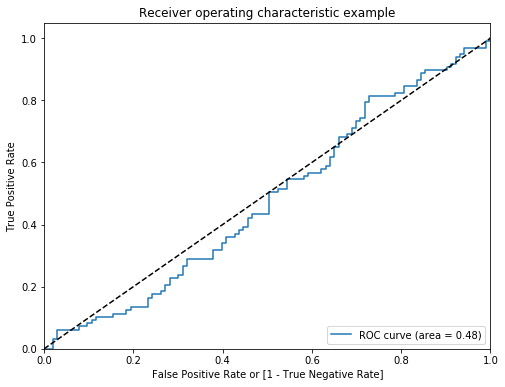

In [159]:
fpr, tpr, thresholds = roc_curve( y_df.actual,
                                       y_df.prob,
                                       drop_intermediate = False )

plt.figure(figsize=(8, 6))
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [155]:
tpr_fpr_df = pd.DataFrame({'tpr':tpr, 'fpr':fpr, 'cutoff': thresholds})

In [161]:
from sklearn.metrics import classification_report
print(classification_report(y_df.actual, y_df.new_labels))

AttributeError: 'DataFrame' object has no attribute 'new_labels'